In [2]:
from torchvision import datasets, transforms
import torch

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST("C:/Users/arman/Desktop/MNIST", download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# download and load the F_MNISt testset 
testset = datasets.MNIST("C:/Users/arman/Desktop/MNIST", download= True, train= False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size= 64, shuffle= True)

In [3]:
# Tensor
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


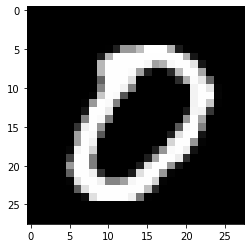

In [4]:
# view 
import matplotlib.pyplot as plt
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r')

In [5]:
# bluid the network architecture 
from torch import nn, optim
import torch.nn.functional as F

class MnistClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128) # This line creates a module for a linear transformation, xW+b w,ith 784 inputs and 256 outputs and assigns it to self.hidden.
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):

        #  tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        
        
        # output so no dropout here
        x = F.log_softmax(self.fc3(x), dim=1)
        
        return x

model = MnistClassifier()
model

MnistClassifier(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [6]:
# Model training

model = MnistClassifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10 # number of epochs to train the model
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0 
    for images, labels in trainloader: # Forward pass
        
        optimizer.zero_grad() # clear the gradients of all optimized variables
        
        log_ps = model(images) # calculate the loss
        loss = criterion(log_ps, labels) 
        loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step() # perform an optimization step (update the weights)
        
        running_loss += loss.item() # update running training loss
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            model.eval() # prepare the model for evaluation
            for images, labels in testloader: # perform a forward pass by passing inputs to the model
                log_ps = model(images) # calculate the loss via log_softmax function 
                test_loss += criterion(log_ps, labels) # update the test loss
                
                ps = torch.exp(log_ps)  # The actual loss probability
                top_p, top_class = ps.topk(1, dim=1) # comparing prdicted class with actual label
                equals = top_class == labels.view(*top_class.shape) # reshaping label size from (64,) to (64,1)
                accuracy += torch.mean(equals.type(torch.FloatTensor)) # make inference

        model.train()        
        train_losses.append(running_loss/len(trainloader)) # Calculate average train loss over an epoch
        test_losses.append(test_loss/len(testloader)) # Calculate average test loss over an epoch

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/10..  Training Loss: 0.496..  Test Loss: 0.229..  Test Accuracy: 0.928
Epoch: 2/10..  Training Loss: 0.257..  Test Loss: 0.158..  Test Accuracy: 0.951
Epoch: 3/10..  Training Loss: 0.208..  Test Loss: 0.137..  Test Accuracy: 0.958
Epoch: 4/10..  Training Loss: 0.184..  Test Loss: 0.128..  Test Accuracy: 0.960
Epoch: 5/10..  Training Loss: 0.167..  Test Loss: 0.115..  Test Accuracy: 0.963
Epoch: 6/10..  Training Loss: 0.158..  Test Loss: 0.110..  Test Accuracy: 0.968
Epoch: 7/10..  Training Loss: 0.147..  Test Loss: 0.107..  Test Accuracy: 0.968
Epoch: 8/10..  Training Loss: 0.140..  Test Loss: 0.094..  Test Accuracy: 0.972
Epoch: 9/10..  Training Loss: 0.139..  Test Loss: 0.103..  Test Accuracy: 0.968
Epoch: 10/10..  Training Loss: 0.130..  Test Loss: 0.099..  Test Accuracy: 0.970


In [7]:
# Save model 
torch.save(model.state_dict(), "MNISTcheckpoint")

In [8]:
# Visualize losses
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

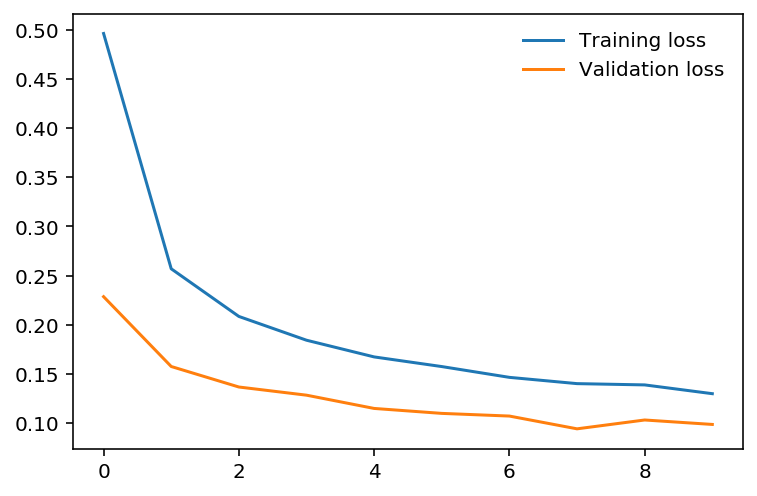

In [9]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

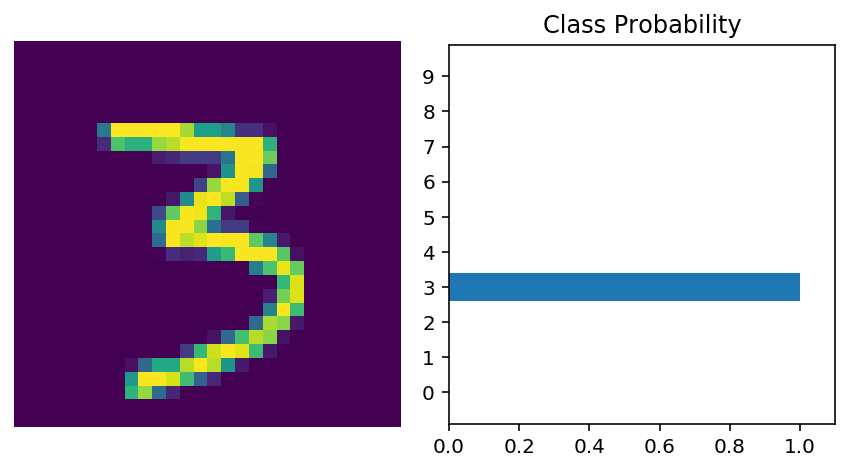

In [14]:
# Test out your network!
import draw

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

#class probabilities (softmax) for img
with torch.no_grad(): # To accelarate computation
    output = model.forward(img) # perform a forward pass here

ps = torch.exp(output)

# Plot the image and probabilities
draw.view_classification(img.view(1, 28, 28), ps, )

In [11]:
# Calculate the total accuracy 

correct_count, all_count = 0, 0

for images,labels in testloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9697
